## [3주차_기다연] word2vec
1. 데이터 크롤링
2. 데이터셋 EDA, 전처리, Tokenization
3. word2vec 모델 생성
4. t-SNE를 이용한 시각화

#### **과제 내용**
참고사이트: [Kaggle Gensim 실습](https://www.kaggle.com/pierremegret/gensim-word2vec-tutorial)
1. 제공된 데이터셋 혹은 본인이 직접 선택한 데이터셋을 통해서 간단한 CBOW/Skip Gram 모델 훈련해보기
2. t-sne를 활용해서 직접 훈련한 Word2Vec 모델에 다양한 단어를 입력해보며 시각화해보기
3. 직접 훈련한 Word2Vec 모델에 관심있는 단어를 입력하고 해당 단어와 유사한 단어들 살펴보기
4. 특정 두 단어 사이의 유사도(거리)를 측정해보고 모델이 잘 훈련되었는지 판단해보기
5. Word2Vec 모델 훈련 시 window_size 등 다양한 초모수 설정 변경해가며 결과 비교해보기
6. gensim 패키지에서 제공하는 사전학습 모델을 활용하여 각자 창의적으로 해보고 싶은 것 해보기

In [ ]:
#Initial Setting (font, display)
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

import matplotlib.pyplot as plt
plt.rc('font', family='NanumBarunGothic') 

import matplotlib
get_ipython().run_line_magic('config', "InlineBackend.figure_format='retina'") #화질 보정

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following NEW packages will be installed:
  fonts-nanum
0 upgraded, 1 newly installed, 0 to remove and 40 not upgraded.
Need to get 9,604 kB of archives.
After this operation, 29.5 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 fonts-nanum all 20170925-1 [9,604 kB]
Fetched 9,604 kB in 2s (5,398 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 76, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
Selecting previously unselected package fonts-nanum.
(Reading database ... 160837 files and d

#### 1) 에브리타임 게시글 데이터 크롤링
참고사이트: [Headless 크롬 크롤링](https://beomi.github.io/gb-crawling/posts/2017-09-28-HowToMakeWebCrawler-Headless-Chrome.html)

In [ ]:
import os
import re
import pandas as pd
import numpy as np
import seaborn as sns
from scipy.sparse import csc_matrix
from scipy.sparse.linalg import svds #SVD
from string import punctuation

#NLP Preprocessing package
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
import string
print('Ready')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
Ready


In [ ]:
!pip3 install selenium

     |████████████████████████████████| 904 kB 5.2 MB/s 


In [ ]:
#Packages for data crawling
from selenium import webdriver
from urllib.request import urlopen
from bs4 import BeautifulSoup as bs
from selenium.webdriver.common.keys import Keys
import time
import sys
import requests

#colab에서 selenium을 사용하기 위해서는 지정해줘야 하는 부분
!apt-get update
!apt install chromium-chromedriver

In [ ]:
url = 'https://everytime.kr/login'

options = webdriver.ChromeOptions()
options.add_argument('--headless')
options.add_argument('--no-sandbox')
options.add_argument("--single-process")
options.add_argument("--window-size=1920,1080")
options.add_argument("--disable-dev-shm-usage")
options.add_argument("disable-gpu")

#에브리타임에서 크롤링해오려는 경우에 참고
options.add_argument("user-agent=Mozilla/5.0 (Macintosh; Intel Mac OS X 10_12_6) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/61.0.3163.100 Safari/537.36")
driver = webdriver.Chrome('chromedriver', options=options)

delay_time = 0.5
driver.implicitly_wait(delay_time)

driver.get(url)

In [ ]:
#에브리타임 로그인 아이디/비밀번호
id = ""
pwd = ""

In [ ]:
#아이디, 비밀번호 접근
input_id = driver.find_element_by_xpath("/html/body/div/form/p[1]/input")
input_id.send_keys(id)

input_pwd = driver.find_element_by_xpath("/html/body/div/form/p[2]/input")
input_pwd.send_keys(pwd)

In [ ]:
#로그인 버튼 클릭
login = driver.find_element_by_xpath("/html/body/div/form/p[3]/input")
login.click()

In [ ]:
#Data Crawling (에브리타임 게시글 데이터)
#게시글 데이터 담을 데이터프레임 생성
everytime_data = pd.DataFrame(columns = ['post'])

#게시글 1000개만 가져오기
#한 페이지당 게시글 20개가 있으므로 50페이지까지 크롤링
for k in range(1, 51): 
  for i in range(1, 21):
    #취업/진로 게시판 (다른 게시판도 설정해주실 수 있습니다.) - 취업/진로 게시판의 경우 url 370507
    url = "https://everytime.kr/370507/p/%d" % k
    driver.get(url)
    info = driver.find_elements_by_xpath("/html/body/div[2]/div[3]/article[%d]/a" % i)
        
    for n in info:
      n.click() #각 게시글로 접속
      everytime_post = []
      try:
        post = driver.find_element_by_xpath("/html/body/div[2]/div[3]/article/a/p")
        post = post.text
        everytime_post.append(post)

        new_data = {'post': post}
        everytime_data = everytime_data.append(new_data, ignore_index=True)
        print('pass')
      except:
        print('error')

In [ ]:
#게시글이 제대로 크롤링 되어왔음을 확인하실 수 있습니다.
#상위 post 5개 확인
pd.set_option('display.max_colwidth', -1) #truncated되지 않고 post 모두 보여주기
everytime_data[:5]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  This is separate from the ipykernel package so we can avoid doing imports until


,post
0,"고려대학교 대외협력처 커뮤니케이션팀에서 근로장학생을 모집합니다.\n\n\n1. 지원자격 : 최소 3개월 이상 근무 가능한 본교(서울캠퍼스) 휴학생 (대학원생, 수료생, 졸업생 불가)\n\n2. 모집인원 : 1명\n\n3. 업무내용 : 행정업무 보조\n\n4. 근무시간 : 09:00 ~ 17:30 (월~금)\n\n방학 단축근무 기간 중 10:00 ~ 17:00\n\n5. 급 여 : 시간당 8,800원\n\n6. 근무기간 : 2021년 7월 29일(목)부터\n\n7. 근무장소 : 본관 부속건물 201호 커뮤니케이션팀\n\n8. 신청방법 : 아래 링크의 신청서를 통해 신청해주시면 개별 연락 예정입니다.\n\nhttps://forms.gle/o7JkkCxXG7yiY22R7\n\n9. 채용기간 : 채용 시까지\n\n10. 문 의 : 02-3290-1061\n\n업무 관련해서 궁금한 게 있을 시에 쪽지 주시면 알려드리겠습니다!"
1,"저는 한참동안 진로 때문에 해매다가, 안정적인 직업 + 공항에 관심이 생겨서 최근 인국공이랑 한국공항공사를 알아보고 있는 3학년 취린이에요.\n다름이 아니라, 공기업 취직(특히 일반직/행정직)에 성공하신, 혹은 준비 중이신 선배님들께 조언을 얻고 싶어서 글을 남깁니다.\n\n1. 보통 NCS 준비는 어느정도의 기간을 잡고 하나요? 사실 자신이 없어서 일찍 준비를 시작하고 싶어서 여쭤봅니다😭\n\n2. 자격증은 어학, 컴활, 한능검만 있어도 괜찮을까요? 현재 컴활 취득을 위해서 열심히 실기 응시중이고, 토익 990점과 토익스피킹 레벨8은 취득한 상태입니다!\n\n3. 자소서나 경험/경력 사항에 쓸거리가 있으려면 인턴경험이 필요할 것 같은데, 선배님들은 인턴을 몇 번 정도 하셨나요?\n\n4. 공기업 취직을 준비할 때 타겟 공기업 3~4곳 정도 잡는게 좋다고 들었는데, 선배님들은 어떤 곳들을 함께 준비하셨나요? 서로 직무나 전공과목이 유사한 곳들 위주로 고르는게 좋겠죠?\n\n5. 4학년 때 해커스같은 학원을 다니면 도움 많이 될까요?\n\n댓글 달아주시거나, 쪽지 주시면 너무너무 감사하겠습니다😊 아시는 만큼만 답해주셔도 좋아요!!"
2,"안녕하세요,\nIT 에듀 테크 스타트업 ‘Major Map’에서\n대학생활 / 전공 관련 인터뷰를 하실 재학생, 졸업생 분들을 모십니다.\n\n✔️지원 가능 학과: 문/이과 전공 ( 경영대 제외 )\n\n✔️활동 내용: 학과 및 대학 생활에 대한 소개 인터뷰\n\nex) 전공에서 어떤 내용을 배우는지 ?\n해당 학과를 선택하게 된 계기는 무엇인지?\n졸업 후 진로는 어떻게 되는지 ?\n전공에 대해 기대했던 점과 다른 부분은 ?\n해당 학과를 희망하는 학생들에게 한 마디 !!\n\nhttps://m.blog.naver.com/majormap20/222421032246\n\n✔️시기 : 편하신 시간대 ( 조율 가능 )\n✔️보수 : 담당자 협의\n\n관심 있으신 분들께서는 저에게 쪽지로\n\n🌟성함 / 소속 대학 / 학번 / 학과 / 연락처\n\n말씀 주시면 담당자와 연결시켜 드리겠습니다 !!\n\n\n\n저와 같이 일했던 정말 좋은 분들이라서\n꼭 추천 드리고 싶어 홍보글 올립니다!\n\n가뜩이나 어려운 코로나 시기에,\n학과/ 학교 생활에 대해서\n재미있게 인터뷰 하실 수 있는 달달한 기회예요!!\n\n많은 참여 부탁 드리겠습니다!!"
3,"안녕하세요, 고려대 선후배 동기분들!\n제가 근무하고 있는 이랜드그룹 ESI에서 전환형 인턴을 모집합니다! (9~10월 인턴)\n\n[지원자격]\n수료자/기졸업자 및 2022년 2월 졸업예정자\n\n[모집직무]\n사업기획\n\n[모집일정]\n2021.07.19(월)~08.01(일) 23시 59분까지\n\n자세한 사항은 아래 사이트 및 오픈채팅방 참고해주시면 감사드리겠습니다 :)\n\n- ESI 공식 홈페이지 : https://sites.google.com/view/sunjack/about-e-land-e-s-i\n- 그룹 채용사이트 : https://www.elandscout.com/\n- ESI 채용 문의 오픈채팅방 : https://open.kakao.com/o/gYgjVeod\n\n많은 관심 부탁드릴게요 :)"
4,토스페이먼츠에서 8/1까지 Tech 직군 공개채용을 진행합니다! 정체되어있는 결제산업에서 혁신적인 변화를 함께 만들고 싶으신 분들은 주저말고 지원해주세요.\n\nhttps://recruit.tosspayments.com/2021


In [ ]:
everytime_data.to_csv('drive/My Drive/21 SUM/KUBIG/방학 NLP 세션/data_crawling.csv')

In [ ]:
len(everytime_data)

877

#### 2) 데이터 전처리
- 정규표현식 이용해서 한글만 남겨두기 (영어, 문자기호 제거)
- pykospacing 이용해서 한국어 띄어쓰기 교정
- hanspell 이용해서 한국어 맞춤법 교정

In [ ]:
everytime_data = pd.read_csv('everytime_data.csv')
del everytime_data['Unnamed: 0']

In [ ]:
#1) 정규표현식 (영어/숫자 기호/문자 제거)
import re

#텍스트 정제 함수: 한글 이외의 문자는 모두 제거
def text_cleaning(text):
    hangul = re.compile('[^ ㄱ-ㅣ가-힣]+') #한글과 띄어쓰기를 제외한 모든 글자 
    #hangul = re.compile('[^ \u3131-\u3163\uac00-\ud7a3]+') 위와 동일
    result = hangul.sub('', str(text))
    return(result)

In [ ]:
for i in range(len(everytime_data)):
    everytime_data.loc[i, 'post_kor'] = text_cleaning(everytime_data['post'][i])
everytime_data.head(3)

,post,post_kor
0,고려대학교 대외협력처 커뮤니케이션팀에서 근로장학생을 모집합니다.\n\n\n1. 지원...,고려대학교 대외협력처 커뮤니케이션팀에서 근로장학생을 모집합니다 지원자격 최소 개월...
1,"저는 한참동안 진로 때문에 해매다가, 안정적인 직업 + 공항에 관심이 생겨서 최근 ...",저는 한참동안 진로 때문에 해매다가 안정적인 직업 공항에 관심이 생겨서 최근 인국...
2,"안녕하세요,\nIT 에듀 테크 스타트업 ‘Major Map’에서\n대학생활 / 전공...",안녕하세요 에듀 테크 스타트업 에서대학생활 전공 관련 인터뷰를 하실 재학생 졸업...


In [ ]:
#2) 띄어쓰기 교정 (PykoSpacing 패키지 사용)
!pip3 install git+https://github.com/haven-jeon/PyKoSpacing.git #한글 띄어쓰기(PyKoSpacing)

In [ ]:
from pykospacing import Spacing
spacing = Spacing()

In [ ]:
cleaned_corpus = []
for sent in everytime_data['post_kor']:
    cleaned_corpus.append(spacing(sent))

In [ ]:
spaced_corpus = cleaned_corpus
everytime_data['post_spaced'] = spaced_corpus
pd.set_option('display.max_colwidth', -1) #truncated되지 않고 post 모두 보여주기
everytime_data.head(3)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  This is separate from the ipykernel package so we can avoid doing imports until


,post,post_kor,post_spaced
0,"고려대학교 대외협력처 커뮤니케이션팀에서 근로장학생을 모집합니다.\n\n\n1. 지원자격 : 최소 3개월 이상 근무 가능한 본교(서울캠퍼스) 휴학생 (대학원생, 수료생, 졸업생 불가)\n\n2. 모집인원 : 1명\n\n3. 업무내용 : 행정업무 보조\n\n4. 근무시간 : 09:00 ~ 17:30 (월~금)\n\n방학 단축근무 기간 중 10:00 ~ 17:00\n\n5. 급 여 : 시간당 8,800원\n\n6. 근무기간 : 2021년 7월 29일(목)부터\n\n7. 근무장소 : 본관 부속건물 201호 커뮤니케이션팀\n\n8. 신청방법 : 아래 링크의 신청서를 통해 신청해주시면 개별 연락 예정입니다.\n\nhttps://forms.gle/o7JkkCxXG7yiY22R7\n\n9. 채용기간 : 채용 시까지\n\n10. 문 의 : 02-3290-1061\n\n업무 관련해서 궁금한 게 있을 시에 쪽지 주시면 알려드리겠습니다!",고려대학교 대외협력처 커뮤니케이션팀에서 근로장학생을 모집합니다 지원자격 최소 개월 이상 근무 가능한 본교서울캠퍼스 휴학생 대학원생 수료생 졸업생 불가 모집인원 명 업무내용 행정업무 보조 근무시간 월금방학 단축근무 기간 중 급 여 시간당 원 근무기간 년 월 일목부터 근무장소 본관 부속건물 호 커뮤니케이션팀 신청방법 아래 링크의 신청서를 통해 신청해주시면 개별 연락 예정입니다 채용기간 채용 시까지 문 의 업무 관련해서 궁금한 게 있을 시에 쪽지 주시면 알려드리겠습니다,고려대학교 대외협력처 커뮤니케이션팀에서 근로장학생을 모집합니다 지원 자격 최소 개월 이상 근무 가능한 본교 서울캠퍼스 휴학생 대학원생 수료생 졸업생 불가 모집인원 명 업무 내용 행정업무 보조 근무시간 월금방 학 단축근무 기간 중 급 여 시간당 원 근무기간 년 월 일 목부터 근무 장소 본관 부속건물 호 커뮤니케이션팀 신청 방법 아래 링크의 신 청서를 통해 신청해주시면 개별 연락 예정입니다 채용기간 채용 시까지 문 의 업무 관련해서 궁금한 게 있을 시에 쪽지 주시면 알려드리겠습니다
1,"저는 한참동안 진로 때문에 해매다가, 안정적인 직업 + 공항에 관심이 생겨서 최근 인국공이랑 한국공항공사를 알아보고 있는 3학년 취린이에요.\n다름이 아니라, 공기업 취직(특히 일반직/행정직)에 성공하신, 혹은 준비 중이신 선배님들께 조언을 얻고 싶어서 글을 남깁니다.\n\n1. 보통 NCS 준비는 어느정도의 기간을 잡고 하나요? 사실 자신이 없어서 일찍 준비를 시작하고 싶어서 여쭤봅니다😭\n\n2. 자격증은 어학, 컴활, 한능검만 있어도 괜찮을까요? 현재 컴활 취득을 위해서 열심히 실기 응시중이고, 토익 990점과 토익스피킹 레벨8은 취득한 상태입니다!\n\n3. 자소서나 경험/경력 사항에 쓸거리가 있으려면 인턴경험이 필요할 것 같은데, 선배님들은 인턴을 몇 번 정도 하셨나요?\n\n4. 공기업 취직을 준비할 때 타겟 공기업 3~4곳 정도 잡는게 좋다고 들었는데, 선배님들은 어떤 곳들을 함께 준비하셨나요? 서로 직무나 전공과목이 유사한 곳들 위주로 고르는게 좋겠죠?\n\n5. 4학년 때 해커스같은 학원을 다니면 도움 많이 될까요?\n\n댓글 달아주시거나, 쪽지 주시면 너무너무 감사하겠습니다😊 아시는 만큼만 답해주셔도 좋아요!!",저는 한참동안 진로 때문에 해매다가 안정적인 직업 공항에 관심이 생겨서 최근 인국공이랑 한국공항공사를 알아보고 있는 학년 취린이에요다름이 아니라 공기업 취직특히 일반직행정직에 성공하신 혹은 준비 중이신 선배님들께 조언을 얻고 싶어서 글을 남깁니다 보통 준비는 어느정도의 기간을 잡고 하나요 사실 자신이 없어서 일찍 준비를 시작하고 싶어서 여쭤봅니다 자격증은 어학 컴활 한능검만 있어도 괜찮을까요 현재 컴활 취득을 위해서 열심히 실기 응시중이고 토익 점과 토익스피킹 레벨은 취득한 상태입니다 자소서나 경험경력 사항에 쓸거리가 있으려면 인턴경험이 필요할 것 같은데 선배님들은 인턴을 몇 번 정도 하셨나요 공기업 취직을 준비할 때 타겟 공기업 곳 정도 잡는게 좋다고 들었는데 선배님들은 어떤 곳들을 함께 준비하셨나요 서로 직무나 전공과목이 유사한 곳들 위주로 고르는게 좋겠죠 학년 때 해커스같은 학원을 다니면 도움 많이 될까요댓글 달아주시거나 쪽지 주시면 너무너무 감사하겠습니다 아시는 만큼만 답해주셔도 좋아요,저는 한참 동안 진로 때문에 해 매다가 안정적인 직업 공항에 관심이 생겨서 최근 인 국공이랑 한국공항공사를 알아보고 있는 학년 취린이에요 다름이 아니라 공기업 취직특히 일반직 행정직에 성공하신 혹은 준비 중이 신 선배님들께 조언을 얻고 싶어서 글을 남깁니 다 보통 준비는 어느 정도의 기간을 잡고 하나요 사실 자신이 없어서 일찍 준비를 시작하고 싶어서 여쭤봅니다 자 격증은 어학 컴활 한 능검만 있어도 괜찮을까요 현재 컴 활 취득을 위해서 열심히 실기 응시 중이고 토익 점과 토익스피킹 레벨은 취득한 상태입니다 자소서나 경험 경력 사항에 쓸거리가 있으려면 인턴 경험이 필요할 것 같은데 선배님들은 인턴을 몇 번 정도 하셨나요 공기업 취직을 준비할 때 타겟 공기업 곳 정도 잡는 게 좋다고 들었는데 선배님들은 어떤 곳들을 함께 준비하 셨나요 서로 직무나 전공과목이 유사한 곳들 위주로 고르는 게 좋겠죠 학년 때 해커스 같은 학원을 다니면 도움 많이 될까 요댓글 달아주시거나 쪽지 주시면 너무너무 감사하겠습니다 아시는 만큼만 답해 주셔도 좋아요
2,"안녕하세요,\nIT 에듀 테크 스타트업 ‘Major Map’에서\n대학생활 / 전공 관련 인터뷰를 하실 재학생, 졸업생 분들을 모십니다.\n\n✔️지원 가능 학과: 문/이과 전공 ( 경영대 제외 )\n\n✔️활동 내용: 학과 및 대학 생활에 대한 소개 인터뷰\n\nex) 전공에서 어떤 내용을 배우는지 ?\n해당 학과를 선택하게 된 계기는 무엇인지?\n졸업 후 진로는 어떻게 되는지 ?\n전공에 대해 기대했던 점과 다른 부분은 ?\n해당 학과를 희망하는 학생들에게 한 마디 !!\n\nhttps://m.blog.naver.com/majormap20/222421032246\n\n✔️시기 : 편하신 시간대 ( 조율 가능 )\n✔️보수 : 담당자 협의\n\n관심 있으신 분들께서는 저에게 쪽지로\n\n🌟성함 / 소속 대학 / 학번 / 학과 / 연락처\n\n말씀 주시면 담당자와 연결시켜 드리겠습니다 !!\n\n\n\n저와 같이 일했던 정말 좋은 분들이라서\n꼭 추천 드리고 싶어 홍보글 올립니다!\n\n가뜩이나 어려운 코로나 시기에,\n학과/ 학교 생활에 대해서\n재미있게 인터뷰 하실 수 있는 달달한 기회예요!!\n\n많은 참여 부탁 드리겠습니다!!",안녕하세요 에듀 테크 스타트업 에서대학생활 전공 관련 인터뷰를 하실 재학생 졸업생 분들을 모십니다지원 가능 학과 문이과 전공 경영대 제외 활동 내용 학과 및 대학 생활에 대한 소개 인터뷰 전공에서 어떤 내용을 배우는지 해당 학과를 선택하게 된 계기는 무엇인지졸업 후 진로는 어떻게 되는지 전공에 대해 기대했던 점과 다른 부분은 해당 학과를 희망하는 학생들에게 한 마디 시기 편하신 시간대 조율 가능 보수 담당자 협의관심 있으신 분들께서는 저에게 쪽지로성함 소속 대학 학번 학과 연락처말씀 주시면 담당자와 연결시켜 드리겠습니다 저와 같이 일했던 정말 좋은 분들이라서꼭 추천 드리고 싶어 홍보글 올립니다가뜩이나 어려운 코로나 시기에학과 학교 생활에 대해서재미있게 인터뷰 하실 수 있는 달달한 기회예요많은 참여 부탁 드리겠습니다,안녕하세요 에듀 테크 스타트업 에서 대학생활 전공 관련 인터뷰를 하실 재학생 졸업생 분들을 모십니다 지원 가능 학과 문이 과 전공 경영대 제외 활동 내용 학과 및 대학 생활에 대한 소개 인터뷰 전공에서 어떤 내용을 배우는 지 해당 학과를 선택하게 된 계기는 무엇인지 졸업 후 진로는 어떻게 되는지 전공에 대해 기대했던 점과 다른 부분은 해당 학과를 희망하는 학생들에게 한 마디 시기 편하신 시간대 조율 가능 보수 담당자 협의 관심 있으신 분들께서는 저에게 쪽지로 성함 소속 대학 학번 학과 연락처 말씀 주시면 담당자와 연결시켜 드리겠습니다 저와 같이 일했던 정말 좋은 분들이라서 꼭 추천 드리고 싶어 홍보 글 올립니다가뜩이나 어려운 코로

In [ ]:
del everytime_data['post']
del everytime_data['post_kor']

In [ ]:
!pip install git+https://github.com/ssut/py-hanspell.git

In [ ]:
#3) 맞춤법 교정 (hanspell 패키지 사용)
from hanspell import spell_checker

corpus = []
for sent in spaced_corpus:
    try:
      spelled_sent = spell_checker.check(sent)
      checked_sent = spelled_sent.checked
      corpus.append(checked_sent)
    except:
      pass

everytime_data['spelled'] = corpus
everytime_data.head(3)

,post_spaced,spelled
0,고려대학교 대외협력처 커뮤니케이션팀에서 근로장학생을 모집합니다 지원 자격 최소 개월 이상 근무 가능한 본교 서울캠퍼스 휴학생 대학원생 수료생 졸업생 불가 모집인원 명 업무 내용 행정업무 보조 근무시간 월금방 학 단축근무 기간 중 급 여 시간당 원 근무기간 년 월 일 목부터 근무 장소 본관 부속건물 호 커뮤니케이션팀 신청 방법 아래 링크의 신 청서를 통해 신청해주시면 개별 연락 예정입니다 채용기간 채용 시까지 문 의 업무 관련해서 궁금한 게 있을 시에 쪽지 주시면 알려드리겠습니다,고려대학교 대외협력처 커뮤니케이션팀에서 근로장학생을 모집합니다 지원 자격 최소 개월 이상 근무 가능한 본교 서울캠퍼스 휴학생 대학원생 수료생 졸업생 불가 모집인원 명 업무 내용 행정업무 보조 근무시간 월은 방 학 단축근무 기간 중 급여 시간당 원 근무기간 연월일 목부터 근무 장소 본관 부속건물 호 커뮤니케이션팀 신청 방법 아래 링크의 신 청서를 통해 신청해주시면 개별 연락 예정입니다 채용기간 채용 시까지 문의 업무 관련해서 궁금한 게 있을 시에 쪽지 주시면 알려드리겠습니다
1,저는 한참 동안 진로 때문에 해 매다가 안정적인 직업 공항에 관심이 생겨서 최근 인 국공이랑 한국공항공사를 알아보고 있는 학년 취린이에요 다름이 아니라 공기업 취직특히 일반직 행정직에 성공하신 혹은 준비 중이 신 선배님들께 조언을 얻고 싶어서 글을 남깁니 다 보통 준비는 어느 정도의 기간을 잡고 하나요 사실 자신이 없어서 일찍 준비를 시작하고 싶어서 여쭤봅니다 자 격증은 어학 컴활 한 능검만 있어도 괜찮을까요 현재 컴 활 취득을 위해서 열심히 실기 응시 중이고 토익 점과 토익스피킹 레벨은 취득한 상태입니다 자소서나 경험 경력 사항에 쓸거리가 있으려면 인턴 경험이 필요할 것 같은데 선배님들은 인턴을 몇 번 정도 하셨나요 공기업 취직을 준비할 때 타겟 공기업 곳 정도 잡는 게 좋다고 들었는데 선배님들은 어떤 곳들을 함께 준비하 셨나요 서로 직무나 전공과목이 유사한 곳들 위주로 고르는 게 좋겠죠 학년 때 해커스 같은 학원을 다니면 도움 많이 될까 요댓글 달아주시거나 쪽지 주시면 너무너무 감사하겠습니다 아시는 만큼만 답해 주셔도 좋아요,
2,안녕하세요 에듀 테크 스타트업 에서 대학생활 전공 관련 인터뷰를 하실 재학생 졸업생 분들을 모십니다 지원 가능 학과 문이 과 전공 경영대 제외 활동 내용 학과 및 대학 생활에 대한 소개 인터뷰 전공에서 어떤 내용을 배우는 지 해당 학과를 선택하게 된 계기는 무엇인지 졸업 후 진로는 어떻게 되는지 전공에 대해 기대했던 점과 다른 부분은 해당 학과를 희망하는 학생들에게 한 마디 시기 편하신 시간대 조율 가능 보수 담당자 협의 관심 있으신 분들께서는 저에게 쪽지로 성함 소속 대학 학번 학과 연락처 말씀 주시면 담당자와 연결시켜 드리겠습니다 저와 같이 일했던 정말 좋은 분들이라서 꼭 추천 드리고 싶어 홍보 글 올립니다가뜩이나 어려운 코로나 시기에 학과 학교 생활에 대해서 재미있게 인터뷰 하실 수 있는 달달한 기 회예요많은 참여 부탁 드리겠습니다,안녕하세요 에듀 테크 스타트업에서 대학생활 전공 관련 인터뷰를 하실 재학생 졸업생분들을 모십니다 지원 가능 학과 문이 과 전공 경영대 제외 활동 내용 학과 및 대학 생활에 대한 소개 인터뷰 전공에서 어떤 내용을 배우는지 해당 학과를 선택하게 된 계기는 무엇인지 졸업 후 진로는 어떻게 되는지 전공에 대해 기대했던 점과 다른 부분은 해당 학과를 희망하는 학생들에게 한 마디 시기 편하신 시간대 조율 가능 보수 담당자 협의 관심 있으신 분들께서는 저에게 쪽지로 성함 소속 대학 학번 학과 연락처 말씀 주시면 담당자와 연결해 드리겠습니다 저와 같이 일했던 정말 좋은 분들이라서 꼭 추천드리고 싶어 홍보 글 올립니다 가뜩이나 어려운 코로나 시기에 학과 학교생활에 대해서 재미있게 인터뷰하실 수 있는 달달한 기 회예요 많은 참여 부탁드리겠습니다


#### 3) Gensim 패키지로 word2vec 모델 훈련
- `Word2Vec()`<br>
In this first step, I set up the parameters of the model one-by-one.
I do not supply the parameter sentences, and therefore leave the model uninitialized, purposefully.

- `build_vocab()`<br>
Here it builds the vocabulary from a sequence of sentences and thus initialized the model.
With the loggings, I can follow the progress and even more important, the effect of min_count and sample on the word corpus. I noticed that these two parameters, and in particular sample, have a great influence over the performance of a model. Displaying both allows for a more accurate and an easier management of their influence.

- `train()`<br>
Finally, trains the model.
The loggings here are mainly useful for monitoring, making sure that no threads are executed instantaneously.



##### **Word2Vec의 파라미터 리스트**
- `min_count` = int<br>Ignores all words with total absolute frequency lower than this - (2, 100)
- `window` = int<br>The maximum distance between the current and predicted word within a sentence. E.g. window words on the left and window words on the left of our target - (2, 10)
- `size` = int<br>Dimensionality of the feature vectors. - (50, 300)
- `sample` = float<br>The threshold for configuring which higher-frequency words are randomly downsampled. Highly influencial. - (0, 1e-5)
- `alpha` = float<br>The initial learning rate - (0.01, 0.05)
- `min_alpha` = float<br>Learning rate will linearly drop to min_alpha as training progresses. To set it: alpha - (min_alpha * epochs) ~ 0.00
- `negative` = int<br>If > 0, negative sampling will be used, the int for negative specifies how many "noise words" should be drown. If set to 0, no negative sampling is used. - (5, 20)
- `workers` = int<br>Use these many worker threads to train the model (=faster training with multicore machines)

In [ ]:
#빈도높은 bigram까지 함께 고려
from gensim.models.phrases import Phrases, Phraser
sent = [row.split() for row in everytime_data['spelled']]
phrases = Phrases(sent, min_count=30, progress_per=10000)

In [ ]:
bigram = Phraser(phrases)
sentences = bigram[sent]

In [ ]:
#Word2vec 모델 생성 .Word2Vec()
import multiprocessing
from gensim.models import Word2Vec

w2v_model = Word2Vec(min_count=5,
                     window=2,
                     size=300,
                     sample=6e-5, 
                     alpha=0.03, 
                     min_alpha=0.0007, 
                     negative=20)

In [ ]:
from time import time

In [ ]:
#Word2vec 사전 생성 .build_vocab()
t = time()
w2v_model.build_vocab(sentences, progress_per=10000)
print('Time to build vocab: {} mins'.format(round((time() - t) / 60, 2)))

Time to build vocab: 0.01 mins


In [ ]:
#Word2vec 모델 훈련 .train()
t = time()
w2v_model.train(sentences, total_examples=w2v_model.corpus_count, epochs=30, report_delay=1)
print('Time to train the model: {} mins'.format(round((time() - t) / 60, 2)))

Time to train the model: 0.09 mins


In [ ]:
w2v_model.init_sims(replace=True)

In [ ]:
#'인턴'과 가장 유사한 단어 찾기
w2v_model.wv.most_similar(positive=["인턴"])

[('경험', 0.9999324083328247),
 ('운영', 0.9999285340309143),
 ('관심을', 0.9999275803565979),
 ('대외활동', 0.9999270439147949),
 ('대해서', 0.9999266266822815),
 ('관심이', 0.9999265074729919),
 ('제작', 0.9999262690544128),
 ('그로스', 0.9999262094497681),
 ('그럼', 0.9999262094497681),
 ('거예요', 0.999925971031189)]

In [ ]:
#2개의 단어 사이 유사도 측정하기
w2v_model.wv.similarity('인턴', '공기업')

0.99991256

In [ ]:
#3개 단어 중 안 어울리는 단어 찾기
w2v_model.wv.doesnt_match(['인턴', '근로장학생', '장학금'])

/usr/local/lib/python3.7/dist-packages/gensim/models/keyedvectors.py:895: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  vectors = vstack(self.word_vec(word, use_norm=True) for word in used_words).astype(REAL)


'인턴'

#### 4) t-SNE를 이용한 시각화

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
 
import seaborn as sns
sns.set_style("darkgrid")

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

In [ ]:
def tsnescatterplot(model, word, list_names):
    arrays = np.empty((0, 300), dtype='f')
    word_labels = [word]
    color_list  = ['red']

    #query 단어의 벡터 표현 (빨강)
    arrays = np.append(arrays, model.wv.__getitem__([word]), axis=0)
    
    #query 단어와 가장 유사한 단어들 찾기
    close_words = model.wv.most_similar([word])
    
    #위에서 찾은 유사한 단어들의 벡터 표현 (파랑)
    for wrd_score in close_words:
        wrd_vector = model.wv.__getitem__([wrd_score[0]])
        word_labels.append(wrd_score[0])
        color_list.append('blue')
        arrays = np.append(arrays, wrd_vector, axis=0)
    
    #각 입력된 list내 단어 벡터 표현 (초록)
    for wrd in list_names:
        wrd_vector = model.wv.__getitem__([wrd])
        word_labels.append(wrd)
        color_list.append('green')
        arrays = np.append(arrays, wrd_vector, axis=0)
        
    #PCA로 300에서 50으로 차원 감소
    reduc = PCA(n_components=50).fit_transform(arrays)
    
    #t-SNE 좌표를 2차원에서 찾아줌
    np.set_printoptions(suppress=True)
    Y = TSNE(n_components=2, random_state=0, perplexity=15).fit_transform(reduc)
    
    df = pd.DataFrame({'x': [x for x in Y[:, 0]],
                       'y': [y for y in Y[:, 1]],
                       'words': word_labels,
                       'color': color_list})
    
    fig, _ = plt.subplots()
    fig.set_size_inches(9, 9)
    
    p1 = sns.regplot(data=df,
                     x="x",
                     y="y",
                     fit_reg=False,
                     marker="o",
                     scatter_kws={'s': 40,
                                  'facecolors': df['color']
                                 }
                    )
    
    #각 벡터 포인트에 annotation 추가
    for line in range(0, df.shape[0]):
         p1.text(df["x"][line],
                 df['y'][line],
                 '  ' + df["words"][line].title(),
                 horizontalalignment='left',
                 verticalalignment='bottom', size='medium',
                 color=df['color'][line],
                 weight='normal'
                ).set_size(15)

    
    plt.xlim(Y[:, 0].min()-50, Y[:, 0].max()+50)
    plt.ylim(Y[:, 1].min()-50, Y[:, 1].max()+50)
            
    plt.title('t-SNE visualization for {}'.format(word.title()))

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


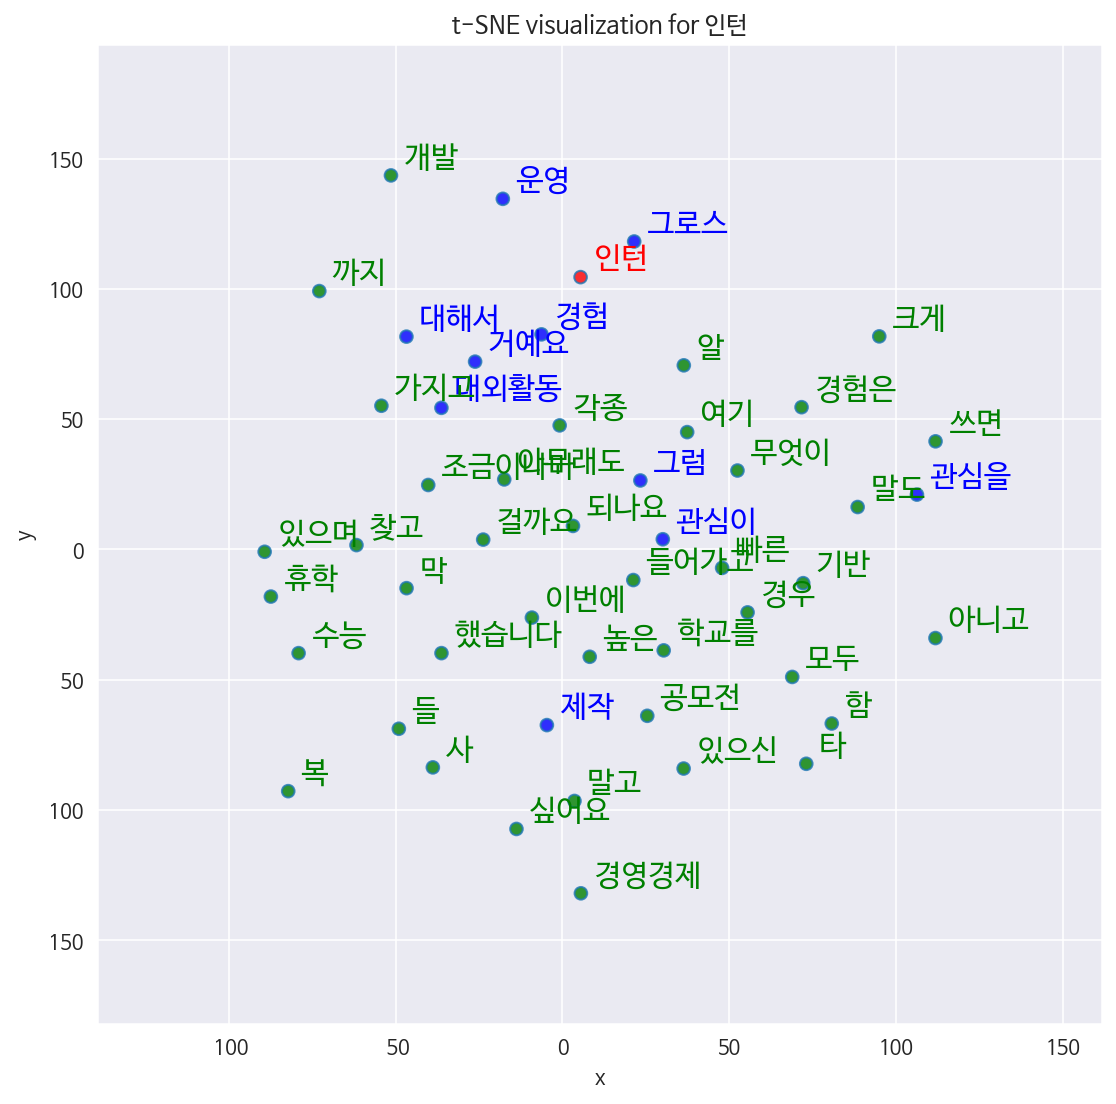

In [ ]:
tsnescatterplot(w2v_model, "인턴", [t[0] for t in w2v_model.wv.most_similar(positive=["인턴"], topn=50)][10:])